In [1]:
from netCDF4 import Dataset
import wrf
import cmocean.cm as cmo
import numpy as np

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap

In [2]:
usgs_file = Dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/usgs/wrfout_test')
wur_file = Dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/wur/wrfout_test')
wur_lcz_file = Dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/wur_lcz/wrfout_test')
modis_file = Dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/modis_lcz/wrfout_test')

In [16]:
import xarray as xr
wur_lcz = xr.open_dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/wur_lcz/wrfout_test')
wur_lcz

<xarray.Dataset> Size: 323MB
Dimensions:                (Time: 2, south_north: 165, west_east: 220,
                            bottom_top: 60, bottom_top_stag: 61,
                            soil_layers_stag: 4, west_east_stag: 221,
                            south_north_stag: 166, seed_dim_stag: 8)
Coordinates:
    XLAT                   (Time, south_north, west_east) float32 290kB ...
    XLONG                  (Time, south_north, west_east) float32 290kB ...
    XTIME                  (Time) datetime64[ns] 16B ...
    XLAT_U                 (Time, south_north, west_east_stag) float32 292kB ...
    XLONG_U                (Time, south_north, west_east_stag) float32 292kB ...
    XLAT_V                 (Time, south_north_stag, west_east) float32 292kB ...
    XLONG_V                (Time, south_north_stag, west_east) float32 292kB ...
Dimensions without coordinates: Time, south_north, west_east, bottom_top,
                                bottom_top_stag, soil_layers_stag,
                                west_east_stag, south_north_stag, seed_dim_stag
Data variables: (12/201)
    Times                  (Time) |S19 38B ...
    LU_INDEX               (Time, south_north, west_east) float32 290kB ...
    ZNU                    (Time, bottom_top) float32 480B ...
    ZNW                    (Time, bottom_top_stag) float32 488B ...
    ZS                     (Time, soil_layers_stag) float32 32B ...
    DZS                    (Time, soil_layers_stag) float32 32B ...
    ...                     ...
    PCB                    (Time, south_north, west_east) float32 290kB ...
    PC                     (Time, south_north, west_east) float32 290kB ...
    LANDMASK               (Time, south_north, west_east) float32 290kB ...
    LAKEMASK               (Time, south_north, west_east) float32 290kB ...
    SST                    (Time, south_north, west_east) float32 290kB ...
    SST_INPUT              (Time, south_north, west_east) float32 290kB ...
Attributes: (12/136)
    TITLE:                            OUTPUT FROM WRF V4.6.0 MODEL
    START_DATE:                      2019-07-23_06:00:00
    SIMULATION_START_DATE:           2019-07-23_06:00:00
    WEST-EAST_GRID_DIMENSION:        221
    SOUTH-NORTH_GRID_DIMENSION:      166
    BOTTOM-TOP_GRID_DIMENSION:       61
    ...                              ...
    ISLAKE:                          21
    ISICE:                           15
    ISURBAN:                         13
    ISOILWATER:                      14
    HYBRID_OPT:                      2
    ETAC:                            0.2

In [4]:
usgs_luindex = wrf.getvar(usgs_file, 'LU_INDEX')
wur_luindex = wrf.getvar(wur_file, 'LU_INDEX')
wur_lcz_luindex = wrf.getvar(wur_lcz_file, 'LU_INDEX')
modis_luindex = wrf.getvar(modis_file, 'LU_INDEX')

lat, lon = wrf.latlon_coords(usgs_luindex)
lat, lon = wrf.to_np(lat), wrf.to_np(lon)
cart_proj = wrf.get_cartopy(usgs_luindex)

In [5]:
c_modis = [
    [0.43, 0.89, 1.0],
    [0.67, 0.94, 1.0],
    [1.0, 0.77, 0.89],
    [1.0, 0.6, 0.8],
    [1.0, 0.0, 1.0],
    [0.50, 0.0, 0.50],
    [0.0, 0.0, 0.50],
    [0.27, 0.27, 1.0],
    [0.2, 0.4, 1.0],
    [0.52, 0.64, 1.0],
    [1.0, 1.0, 1.0],  # URBAN IN ORIGINAL FILE
    [0.8, 0.8, 0.8],
    [0.70, 0.70, 0.70],
    [0.0, 0.0, 0.0],
    [0.6, 0.6, 0.6],
    [0.35, 0.35, 0.35],
    [0.50, 0.50, 0.0],
    [0.0, 0.36, 0.0],
    [0.0, 0.50, 0.0],
    [0.2, 0.6, 0.4],
    [0.62, 0.84, 0.0],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.70, 0.70, 0.70],
    [0.83, 1.0, 0.35],
    [1.0, 1.0, 0.0],
    [1.0, 0.72, 0.44],
    [1.0, 0.6, 0.0],
    [1.0, 0.4, 0.0],
    [1.0, 0.0, 0.0],
    [0.64, 0.44, 1.0],
    [0.74, 0.29, 0.0],
    [0.67, 0.0, 0.22],
    [0.52, 0.0, 0.0],
]

c_usgs = np.array([
    [1,0,0],          #  1 Urban and Built-up Land
    [1,1,0],          #! 2 Dryland Cropland and Pasture
    [1,1,.2],         #  3 Irrigated Cropland and Pasture
    [1,1,.3],         #  4 Mixed Dryland/Irrigated Cropland and Pasture
    [.7,.9,.3],       #  5 Cropland/Grassland Mosaic
    [.7,.9,.3],       #  6 Cropland/Woodland Mosaic
    [0,1,0],          #  7 Grassland
    [.3,.7,0],        #  8 Shrubland
    [.82,.41,.12],    #  9 Mixed Shrubland/Grassland
    [1,.84,.0],       #  10 Savanna
    [.2,.8,.4],       #  11 Deciduous Broadleaf Forest
    [.2,.8,.2],       #  12 Deciduous Needleleaf Forest
    [0,.4,.2],        #  13 Evergreen Broadleaf Forest
    [0,.4,0],         #! 14 Evergreen Needleleaf Forest 
    [.2,.6,.2],       #  15 Mixed Forests
    [0,0,.88],        #  16 Water Bodies
    [0,1,1],          #! 17 Herbaceous Wetlands
    [.2,1,1],         #  18 Wooden Wetlands
    [.914,.914,.7],   #  19 Barren or Sparsely Vegetated
    [.86,.08,.23],    #  20 Herbaceous Tundraa
    [.86,.08,.23],    #  21 Wooded Tundra
    [.97,.5,.31],     #! 22 Mixed Tundra
    [.91,.59,.48],   #! 23 Barren Tundra
    [1,1,1]          #! 24 Snow and Ice
    ])



cmap = LinearSegmentedColormap.from_list('luse', c_usgs, N=24)
levels = np.arange(0, 24)
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

cmap2 = LinearSegmentedColormap.from_list('luse', c_modis, N=61)
levels2 = np.arange(0, 61)
norm2 = BoundaryNorm(levels2, ncolors=cmap2.N, clip=True)

In [6]:
ax_options = {
    'color': 'black',
    'linestyle': 'dotted',
    'linewidth': 0.5,
    'zorder': 103,
    'draw_labels': True,
    'x_inline': False,
    'y_inline': False,
}
title_options = {
    'loc': 'left',
    'fontsize': 'xx-large',
    'fontweight': 'bold',
}
extent = [np.min(lon), np.max(lon), np.min(lat), np.max(lat)]

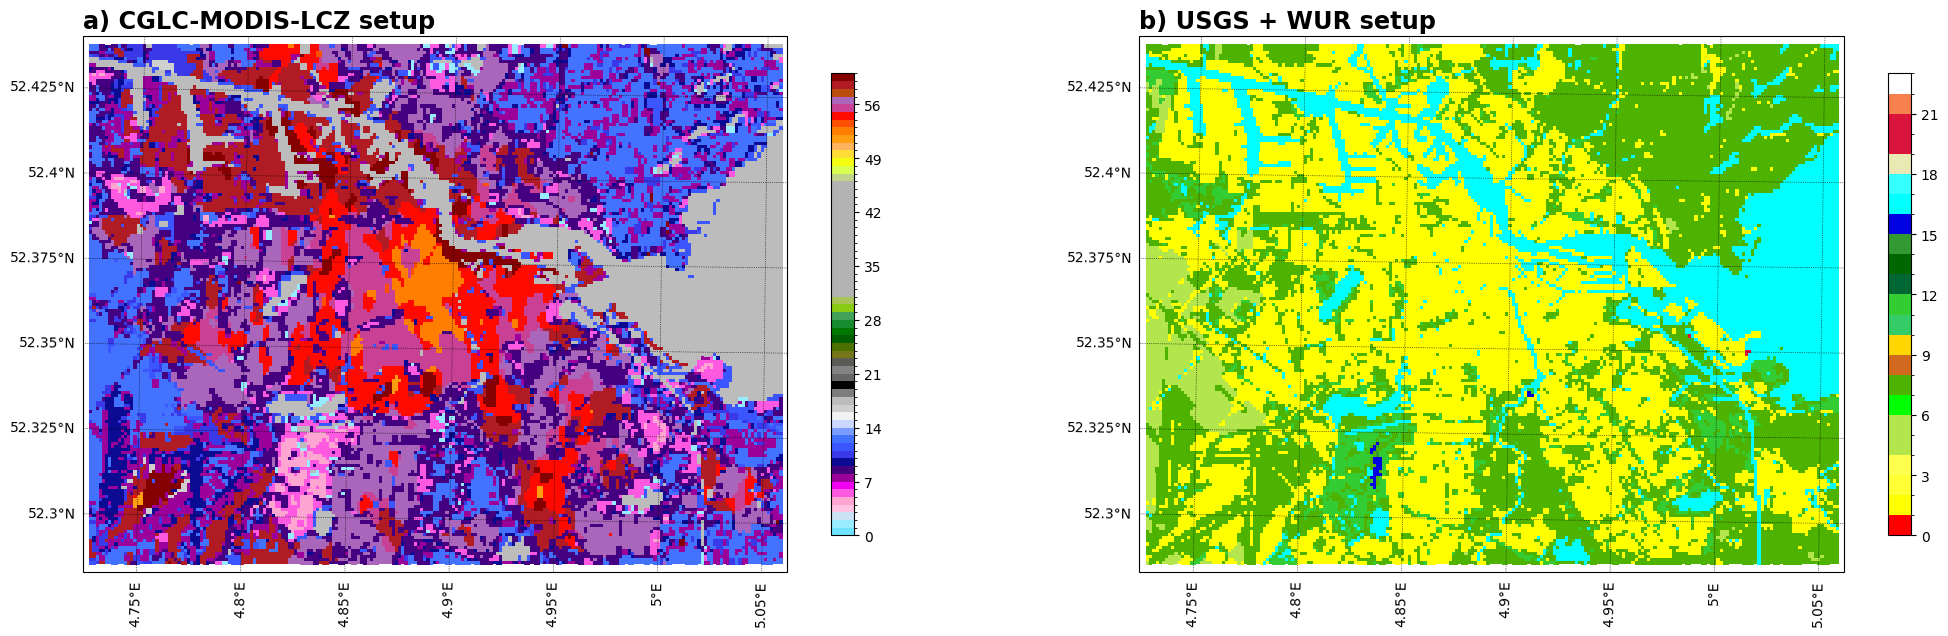

In [14]:
fig = plt.figure(figsize=(25, 10))
ax1 = fig.add_subplot(1, 2, 1, projection=cart_proj)
gl1 = ax1.gridlines(**ax_options)
gl1.right_labels = False
gl1.top_labels = False
ax1.set_extent(extent)
ct1 = ax1.pcolormesh(
    lon, lat, wrf.to_np(modis_luindex), cmap=cmap2, norm=norm2, transform=ccrs.PlateCarree()
)
ax1.coastlines(linewidth=1.0, resolution='10m')
ax1.set_title('a) CGLC-MODIS-LCZ setup', **title_options)
cbar1 = fig.colorbar(ct1, ax=ax1, shrink=0.6)
#cbar1.ax.set_yticklabels(labels)

ax2 = fig.add_subplot(1, 2, 2, projection=cart_proj)
gl2 = ax2.gridlines(**ax_options)
gl2.right_labels = False
gl2.top_labels = False
ax2.set_extent(extent)
ct2 = ax2.pcolormesh(
    lon, lat, wrf.to_np(wur_luindex), cmap=cmap, norm=norm, transform=ccrs.PlateCarree()
)
ax1.coastlines(linewidth=1.0, resolution='10m')
ax2.set_title('b) USGS + WUR setup', **title_options)
cbar2 = fig.colorbar(ct2, ax=ax2, shrink=0.6)

In [18]:
usgs_T2 = wrf.getvar(usgs_file, 'T2')
wur_T2 = wrf.getvar(wur_file, 'T2')
wur_lcz_T2 = wrf.getvar(wur_lcz_file, 'T2')
modis_T2 = wrf.getvar(modis_file, 'T2')

lat, lon = wrf.latlon_coords(usgs_T2)
cart_proj = wrf.get_cartopy(usgs_T2)

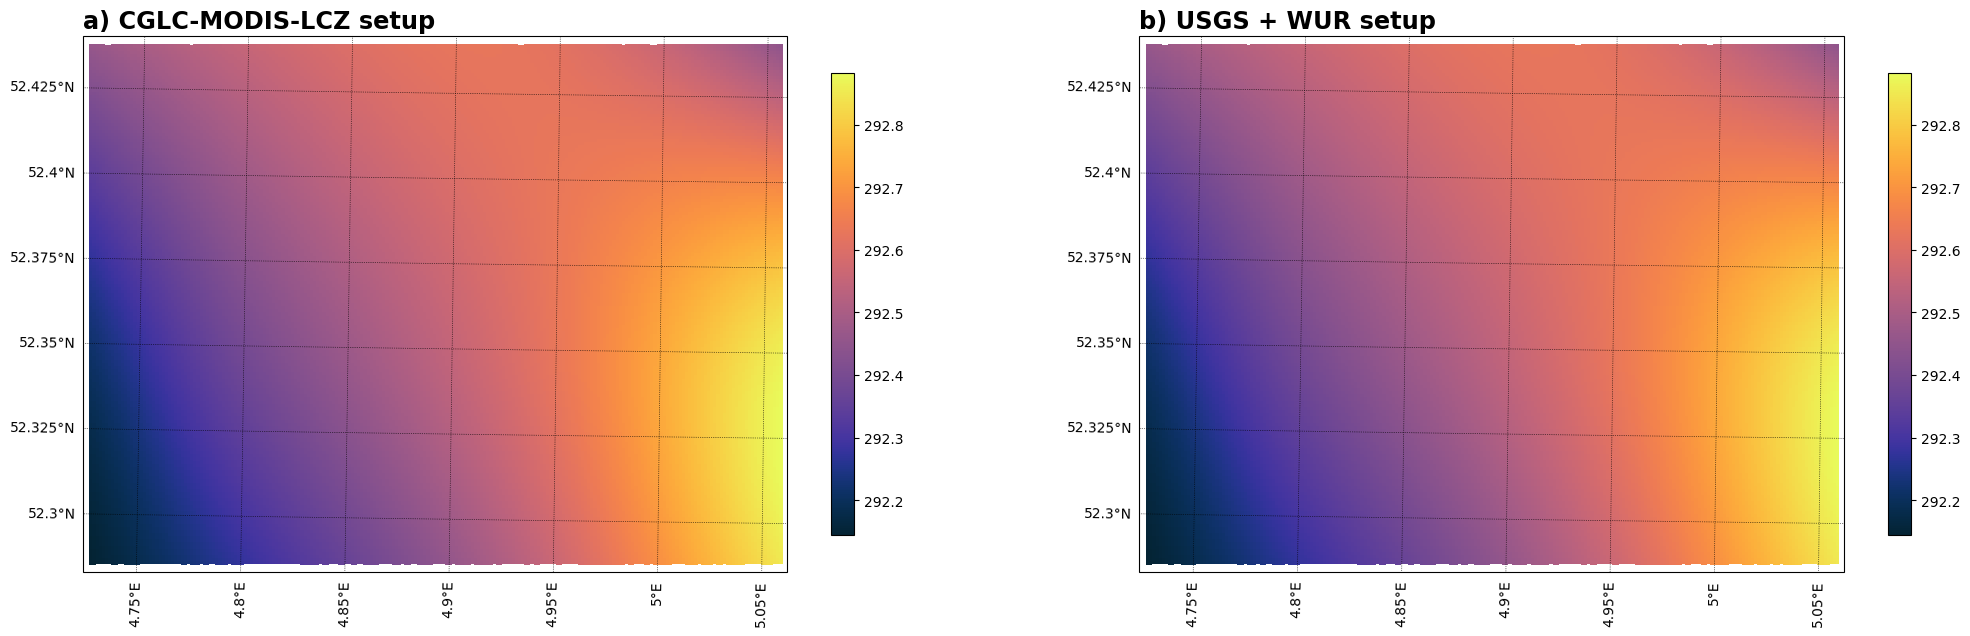

In [19]:
fig = plt.figure(figsize=(25, 10))
ax1 = fig.add_subplot(1, 2, 1, projection=cart_proj)
gl1 = ax1.gridlines(**ax_options)
gl1.right_labels = False
gl1.top_labels = False
ax1.set_extent(extent)
ct1 = ax1.pcolormesh(
    lon, lat, wrf.to_np(wur_lcz_T2), cmap=cmo.thermal, transform=ccrs.PlateCarree()
)
ax1.coastlines(linewidth=1.0, resolution='10m')
ax1.set_title('a) CGLC-MODIS-LCZ setup', **title_options)
cbar1 = fig.colorbar(ct1, ax=ax1, shrink=0.6)

ax2 = fig.add_subplot(1, 2, 2, projection=cart_proj)
gl2 = ax2.gridlines(**ax_options)
gl2.right_labels = False
gl2.top_labels = False
ax2.set_extent(extent)
ct2 = ax2.pcolormesh(
    lon, lat, wrf.to_np(wur_T2), cmap=cmo.thermal, transform=ccrs.PlateCarree()
)
ax1.coastlines(linewidth=1.0, resolution='10m')
ax2.set_title('b) USGS + WUR setup', **title_options)
cbar2 = fig.colorbar(ct2, ax=ax2, shrink=0.6)

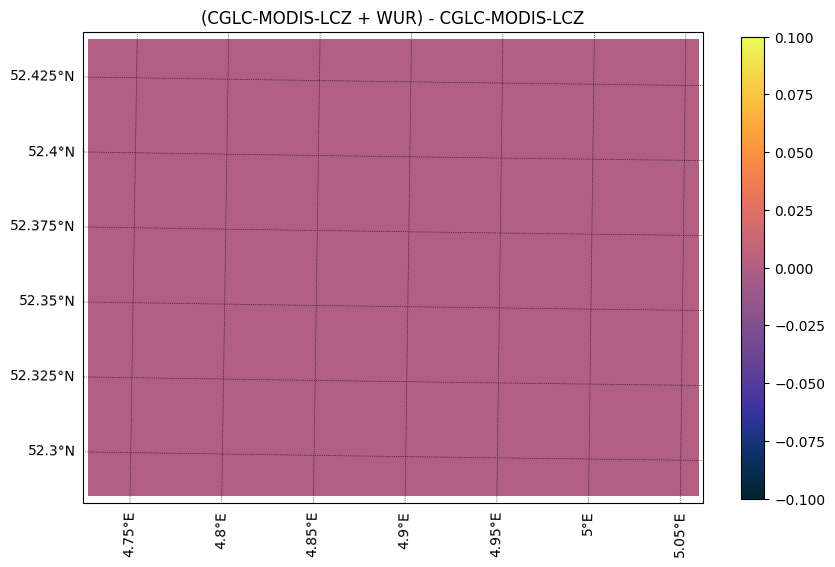

In [20]:
diff = wur_lcz_T2 - modis_T2

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(1, 1, 1, projection=cart_proj)
gl1 = ax1.gridlines(**ax_options)
gl1.right_labels = False
gl1.top_labels = False
ax1.set_extent(extent)
ct1 = ax1.pcolormesh(
    lon, lat, diff, cmap=cmo.thermal, transform=ccrs.PlateCarree()
)
ax1.coastlines(linewidth=1.0, resolution='10m')
ax1.set_title('(CGLC-MODIS-LCZ + WUR) - CGLC-MODIS-LCZ')
cbar1 = fig.colorbar(ct1, ax=ax1, shrink=0.6)

In [21]:
## Try nest
wur_lcz_d4 = Dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/wur_lcz/wrfout_test')
wur_lcz_d1 = Dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/wur_lcz/wrfout_test1')
wur_lcz_d2 = Dataset('/home/cdonnely/Urban-M4/misc/workflows/snakemake/output/wur_lcz/wrfout_test2')


In [22]:
d1_T2 = wrf.getvar(wur_lcz_d1, 'T2')
d2_T2 = wrf.getvar(wur_lcz_d2, 'T2')
d4_T2 = wrf.getvar(wur_lcz_d4, 'T2')

In [23]:
# Get the latitude and longitude points
lats, lons = wrf.latlon_coords(d1_T2)
lats2,lons2 = wrf.latlon_coords(d2_T2)
lats3,lons3 = wrf.latlon_coords(d4_T2)


# Get the cartopy mapping object (use original data, rather than any processed data)
cart_proj = wrf.get_cartopy(d1_T2)

/home/cdonnely/wrf-analysis/.venv/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1768: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)
/home/cdonnely/wrf-analysis/.venv/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1768: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


Text(0.5, 1.0, 'TEMP at 2 M\n2019-07-23T06:00:00.000000000')

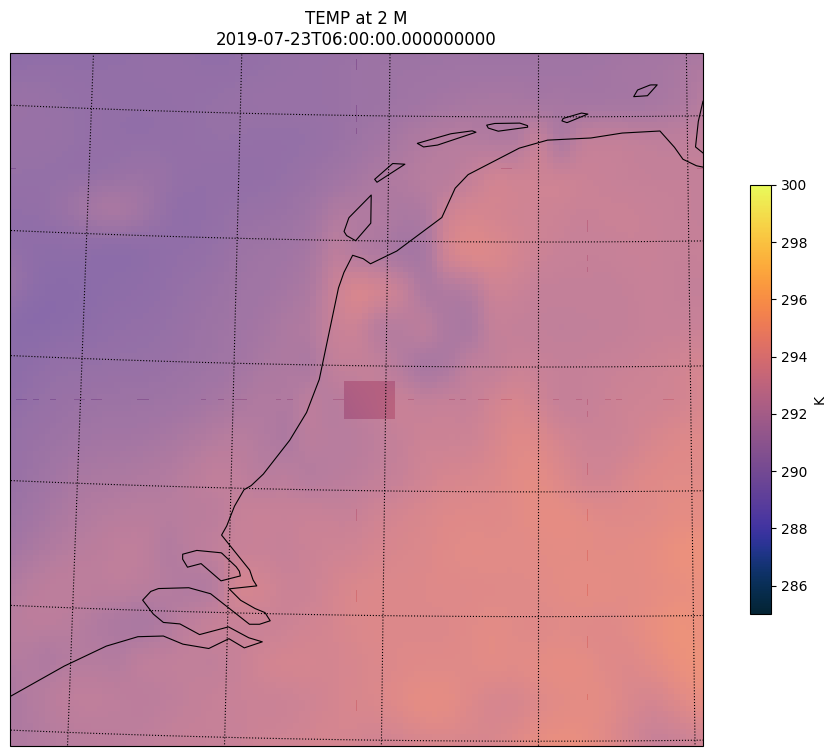

In [30]:
# Create a figure
fig = plt.figure(figsize=(12,9))
# Set the GeoAxes to the projection used by WRF
ax = plt.axes(projection=cart_proj)

# Add coastlines
ax.coastlines('50m', linewidth=0.8)

# Plot contours
# plt.pcolormesh(wrf.to_np(lons), wrf.to_np(lats), wrf.to_np(d1_T2), 
#                transform=ccrs.PlateCarree(), cmap=cmo.thermal, vmin=285, vmax=300, alpha=0.7)

plt.pcolormesh(wrf.to_np(lons2), wrf.to_np(lats2), wrf.to_np(d2_T2), 
                transform=ccrs.PlateCarree(), cmap=cmo.thermal, vmin=285, vmax=300, alpha=0.8)

plt.pcolormesh(wrf.to_np(lons3), wrf.to_np(lats3), wrf.to_np(d4_T2), 
                transform=ccrs.PlateCarree(), cmap=cmo.thermal, vmin=285, vmax=300)

# Add a color bar
cbar = plt.colorbar(ax=ax, shrink=.62)
cbar.set_label(d1_T2.units)

# Add the gridlines
ax.gridlines(color="black", linestyle="dotted")

plt.title(d1_T2.description+'\n'+str(d1_T2.Time.values))